In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

key = random.PRNGKey(0)

# Trigonometric landscape

First we will define a generator of trigonometric functions and a procedure to compute exact average.

In [2]:
def int_to_list(n, size):
    n_str = format(n, 'b')
    assert len(n_str)<=size, 'Integer {} too big to be converted to size {}'.format(n, size)
    
    zero_pad = '0'*(size-len(n_str))
    n_str = zero_pad + n_str
    
    return [int(b) for b in n_str]

def all_binary_strings(size):
    max_n = int('1'*size, 2)+1
    return [int_to_list(n, size) for n in range(max_n)]


def trigonometric_landscape(coeffs, n_angles):

#     assert n_angles % 1 == 0, 'Number of coefficients must be 2**n, got len(coeffs) {}'.format(len(coeffs))
    powers = 1-jnp.array(all_binary_strings(int(n_angles)))

    def f(angles):
        cos_sin_array = jnp.cos(angles/2)**powers * jnp.sin(angles/2)**(1-powers)
        cos_sin_monomials = jnp.prod(cos_sin_array, axis=1)

#         return (coeffs*cos_sin_monomials).sum()
        return jnp.tensordot(cos_sin_monomials, coeffs, axes=1)
    
    return f

def trigonometric_coefficients(f, n_angles):
    all_vertices = jnp.pi*jnp.array(all_binary_strings(int(n_angles)))
    return vmap(f)(all_vertices)

This should illustrate what this function is doing.

CPU times: user 492 ms, sys: 3.26 ms, total: 495 ms
Wall time: 497 ms


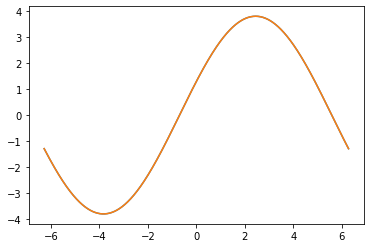

In [3]:
%%time
coeffs0=jnp.array([1, 2, 3, 4], dtype='float32')
n_angles0 = int(jnp.log2(len(coeffs0)))

f0 = trigonometric_landscape(coeffs0, n_angles0)

x_sweep = jnp.linspace(-2*jnp.pi, 2*jnp.pi, 1000)
y = 0.3

plt.plot(x_sweep, vmap(lambda x: f0(jnp.array([x, y], dtype='float32')))(x_sweep))
plt.plot(x_sweep, jnp.cos(x_sweep/2)*jnp.cos(y/2)+
         2*jnp.cos(x_sweep/2)*jnp.sin(y/2)+
         3*jnp.sin(x_sweep/2)*jnp.cos(y/2)+
         4*jnp.sin(x_sweep/2)*jnp.sin(y/2))

In [4]:
def exact_average(F, n_angles):
    grid_points = jnp.pi*jnp.array(all_binary_strings(n_angles))
    F_grid = vmap(F)(grid_points)
    
    return F_grid.sum()/len(grid_points)

def approximate_average(F, n_angles, n_samples, key):
    grid_points = jnp.pi*jnp.array(all_binary_strings(n_angles))
    grid_points = random.permutation(key, grid_points)
    grid_points = grid_points[:n_samples]
    
    F_grid = vmap(F)(grid_points)
    
    return F_grid.sum()/len(grid_points)

Test.

In [5]:
key, subkey = random.split(key)
n_angles = 10
coeffs = random.uniform(subkey, shape=(2**n_angles, ), minval=0, maxval=1)


print((coeffs**2).sum()/2**n_angles)
print(exact_average(lambda angles: trigonometric_landscape(coeffs, n_angles)(angles)**2, n_angles))

0.34455547
0.34455535


In [6]:
%%time
n_angles = 12
key, subkey = random.split(key)
coeffs = random.uniform(subkey, shape=(2**n_angles, ), minval=0, maxval=1)
exact_avg = (coeffs**2).sum()/2**n_angles
F = lambda angles: trigonometric_landscape(coeffs, n_angles)(angles)**2
F=jit(F)

average_list = []
for i in range(n_angles):
    key, subkey = random.split(key)
    average_i = approximate_average(F, n_angles, 2**i, subkey)
    average_list.append(average_i)

CPU times: user 9.06 s, sys: 8.05 ms, total: 9.07 s
Wall time: 4.83 s


number of angles: 12


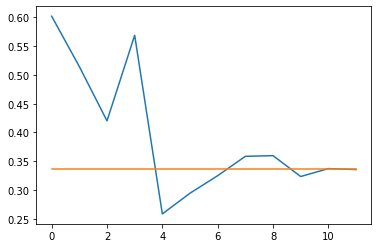

In [7]:
print('number of angles: {}'.format(n_angles))
plt.plot(average_list)
plt.plot([exact_avg]*n_angles)

# Average conjecture test

Now we can test the average conjecture.

In [136]:
n_qubits = 3
a = Ansatz(n_qubits, 'cx', placements={'free':[[1,2], [0,1],[0, 2]]})
# u_func = lambda angs: a.unitary(jnp.array([angs[0], 0, 0, 0, 0, 0], dtype='float32'))
zero_angles = jnp.zeros((a.n_angles, ))
restrinced_angles = lambda angs: zero_angles.at[9].set(angs[0]).at[15].set(angs[1])
u_func = lambda angs: a.unitary(restrinced_angles(angs))
n_angles = 1
a.circuit(restrinced_angles((1, 2))).draw()

┌───────┐┌───────┐┌───────┐                            ┌───────┐┌───────┐»
q_0: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├─────────────────────────■──┤ RY(0) ├┤ RX(0) ├»
     ├───────┤├───────┤├───────┤     ┌───────┐┌───────┐┌─┴─┐├───────┤├───────┤»
q_1: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├──■──┤ RY(1) ├┤ RX(0) ├┤ X ├┤ RY(2) ├┤ RX(0) ├»
     ├───────┤├───────┤├───────┤┌─┴─┐├───────┤├───────┤└───┘└───────┘└───────┘»
q_2: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├┤ X ├┤ RY(0) ├┤ RX(0) ├───────────────────────»
     └───────┘└───────┘└───────┘└───┘└───────┘└───────┘                       »
«          ┌───────┐┌───────┐
«q_0: ──■──┤ RY(0) ├┤ RX(0) ├
«       │  └───────┘└───────┘
«q_1: ──┼────────────────────
«     ┌─┴─┐┌───────┐┌───────┐
«q_2: ┤ X ├┤ RY(0) ├┤ RX(0) ├
«     └───┘└───────┘└───────┘

In [141]:
def A_and_B(angles):
    n_angles = len(angles)
    R = 1j*jnp.kron(y_mat, jnp.identity(2**(n_qubits-1)))
    
    W0 = u_func(jnp.zeros((n_angles), dtype='float32'))
    W = u_func(angles)
    
    A = trace_prod(W0, W)
    B = trace_prod(W0, R@W)
    
    return A, B

def A_squared(angles):
    A, _ = A_and_B(angles)
    return A*A.conj()

def B_squared(angles):
    _, B = A_and_B(angles)
    return B*B.conj()

def A_bar_B(angles):
    A, B = A_and_B(angles)
    return A*B.conj()

In [142]:
print(exact_average(A_squared, n_angles))
print(exact_average(B_squared, n_angles))
print(exact_average(A_bar_B, n_angles))

(16+0j)
0j
0j


# Average learning

In [16]:
def optimize_first_angle(f, n_angles, average_func):
    if n_angles == 1:
        return min_angle(lambda ang: f(jnp.array((ang, ))))
    
    def f_to_average(ang, angs):
        angles = jnp.concatenate([jnp.array([ang]), angs])
        return f(angles)
    
    def f1(ang):
        return average_func(lambda angs: f_to_average(ang, angs), n_angles-1)
    
    return min_angle(f1)

def average_learn(u_func, u_target, n_angles, average_func):
    
    def loss0(angles):
        return disc2(u_func(angles), u_target)
    
    optimal_angles = jnp.array([], dtype='float32')
    for n in range(n_angles):
        def loss(angs):
            angles = jnp.concatenate([optimal_angles, angs])
            return loss0(angles)
        n_angs = n_angles - n
        new_angle = optimize_first_angle(loss, n_angs, average_func)
        optimal_angles = jnp.append(optimal_angles, new_angle)

    return optimal_angles

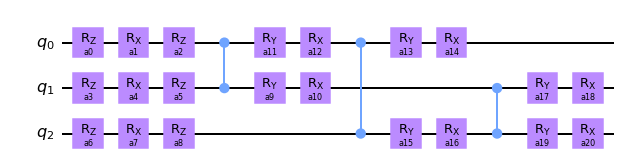

In [114]:
a = Ansatz(3, 'cz', placements={'free':[[1,0], [0, 2], [1, 2]]})
u_target = a.unitary(jnp.array(range(1, a.n_angles+1), dtype='float32'))
a.circuit().draw(output='mpl')

In [115]:
u_restricted = lambda angs: a.unitary(jnp.concatenate([jnp.zeros(shape=(9,)), angs]))
u_target_restricted = u_restricted(jnp.array(range(0, a.n_angles-9),dtype='float32'))

In [116]:
opt_angles = average_learn(u_restricted, u_target_restricted, a.n_angles-9, exact_average)

In [117]:
print(opt_angles)
print(disc2(u_restricted(opt_angles),u_target_restricted))

[ 1.5707964   1.5707964  -0.         -0.         -0.9375348   1.9304514
  0.7853982  -1.5707964   1.5391778  -0.42477575  1.2185782   3.5698256 ]
0.68964493


# Coefficints distribution

Check `trigonometric_coefficients'.

In [34]:
# Reconstruction from coefficients.
n_angles_rnd = 10
coeffs_rnd = random.uniform(random.PRNGKey(0), shape=(2**n_angles_rnd,), minval=0, maxval=10)
f_rnd = trigonometric_landscape(coeffs_rnd, n_angles_rnd)
get_coeffs_rnd = trigonometric_coefficients(f_rnd, n_angles_rnd)

print(coeffs_rnd)
print(get_coeffs_rnd)

[0.94779134 2.8464484  3.5750294  ... 9.188044   5.129981   5.34206   ]
[0.94779134 2.8464484  3.5750294  ... 9.188042   5.1299796  5.342058  ]


In [35]:
# Reconstruction from funcion.
get_f_rnd = trigonometric_landscape(get_coeffs_rnd, n_angles_rnd)

angles_rnd_sample = random.uniform(random.PRNGKey(0), shape=(n_angles_rnd, ), minval=0, maxval=2*jnp.pi)

print(f_rnd(angles_rnd_sample))
print(get_f_rnd(angles_rnd_sample))

5.2657743
5.2657743


In [48]:
a = Ansatz(3, 'cz', placements={'free':[[1,0], [1,2]]})
u_target = a.unitary(jnp.array(range(1, a.n_angles+1), dtype='float32'))
a.circuit().draw(output='mpl')

tr_func = jit(lambda angles: trace_prod(u_target, a.unitary(angles)))
tr_coeffs = trigonometric_coefficients(tr_func, a.n_angles)
tr_func_check = lambda angles: trigonometric_landscape(tr_coeffs, a.n_angles)(angles)

In [49]:
angles = random.uniform(random.PRNGKey(1), shape=(a.n_angles, ), minval=0, maxval=2*jnp.pi)
print(tr_func(angles))
print(tr_func_check(angles))

(-0.5539855-0.1016594j)
(-0.55398566-0.10165937j)


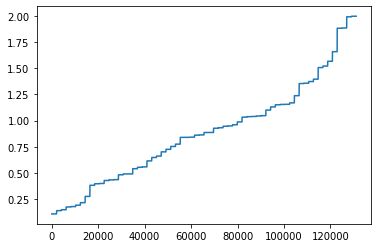

In [50]:
plt.plot(jnp.sort(jnp.abs(tr_coeffs)))

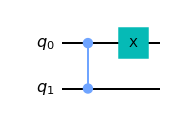

In [13]:
qc = QuantumCircuit(2)
qc.cz(0, 1)
qc.x(0)
u_qc = Operator(qc.reverse_bits()).data

qc.draw(output='mpl')

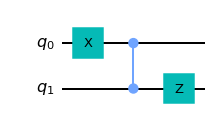

In [14]:
cq = QuantumCircuit(2)
cq.x(0)
cq.cz(0, 1)
cq.z(1)
u_cq = Operator(cq.reverse_bits()).data

cq.draw(output='mpl')

In [15]:
print(jnp.allclose(u_qc, u_cq))

True


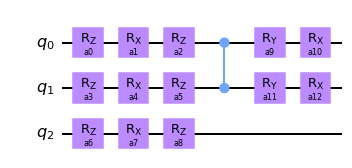

In [16]:

a.circuit().draw(output='mpl')

In [8]:
%%time
a = Ansatz(3, 'cz', placements={'free':[[0,1], [1, 2], [0, 2]]})
u_coeffs = trigonometric_coefficients(jit(a.unitary), a.n_angles)

CPU times: user 24.1 s, sys: 1.81 s, total: 25.9 s
Wall time: 25.7 s


In [9]:
%%time
u_0 = u_coeffs[0]
prods = vmap(jit(lambda u: trace_prod(u_0, u)))(u_coeffs)
prods_abs = vmap(jnp.abs)(jnp.array(prods))
prods_abs = prods_abs/prods_abs[0]

CPU times: user 14.7 s, sys: 1.36 s, total: 16.1 s
Wall time: 12.7 s


In [10]:
zers = jnp.where(jnp.abs(prods_abs)<1e-7)[0]
ons = jnp.where(jnp.abs(prods_abs-1)<1e-7)[0]

print('ones: {}, zeros: {}, sum: {}, total: {}'.format(len(ons), len(zers),len(ons)+len(zers),len(prods_abs)))
print('ratio: {}'.format(len(prods_abs)/len(ons)))
print('guess:: {}'.format(4**a.n_qubits))

ones: 32768, zeros: 2064384, sum: 2097152, total: 2097152
ratio: 64.0
guess:: 64
